# Related to Figure4B

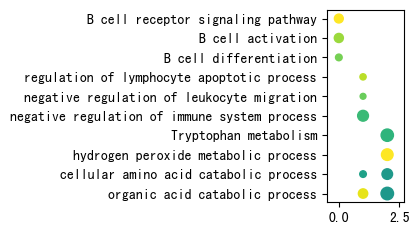

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir('/data/yuchen_data/Stereo_seq/All_Figures/version2/Figure4/1.data/2.kegg_go/')

df_1_1 = pd.read_csv('C1_BP.txt', index_col=0, sep='\t')
df_1_2 = pd.read_csv('C1_KEGG.txt', index_col=0, sep='\t')
df_1 = pd.concat((df_1_1, df_1_2))

df_2 = pd.read_csv('C2_BP.txt', index_col=0, sep='\t')

df_3_1 = pd.read_csv('C3_BP.txt', index_col=0, sep='\t')
df_3_2 = pd.read_csv('C3_KEGG.txt', index_col=0, sep='\t')
# df_3_2.index = df_3_2['ID']
df_3 = pd.concat((df_3_1, df_3_2))

df_1['Gene Ratio'] = [int(x.split('/')[0]) / int(x.split('/')[1]) for x in df_1['GeneRatio']]
df_2['Gene Ratio'] = [int(x.split('/')[0]) / int(x.split('/')[1]) for x in df_2['GeneRatio']]
df_3['Gene Ratio'] = [int(x.split('/')[0]) / int(x.split('/')[1]) for x in df_3['GeneRatio']]


df_1['-log10p'] = -np.log10(df_1['p.adjust'])
df_2['-log10p'] = -np.log10(df_2['p.adjust'])
df_3['-log10p'] = -np.log10(df_3['p.adjust'])


dic = {}
dic['cluster1'] = ['B cell activation', 'B cell receptor signaling pathway', 'B cell differentiation']
dic['cluster2'] = ['negative regulation of immune system process','regulation of lymphocyte apoptotic process','negative regulation of leukocyte migration']
dic['cluster3'] = ['hydrogen peroxide metabolic process', 'cellular amino acid catabolic process', 'organic acid catabolic process', 'Tryptophan metabolism']

used_items = dic['cluster1'] + dic['cluster2'] + dic['cluster3']
df_1 = df_1[df_1['Description'].isin(used_items)]
df_2 = df_2[df_2['Description'].isin(used_items)]
df_3 = df_3[df_3['Description'].isin(used_items)]

my_order = list(df_1[df_1['Description'].isin(dic['cluster1'])].sort_values('-log10p', ascending=False)['Description']) + list(df_2[df_2['Description'].isin(dic['cluster2'])].sort_values('-log10p', ascending=False)['Description']) + list(df_3[df_3['Description'].isin(dic['cluster3'])].sort_values('-log10p', ascending=False)['Description'])


my_order = ['B cell receptor signaling pathway',
 'B cell activation',
 'B cell differentiation',
 'regulation of lymphocyte apoptotic process',
 'negative regulation of leukocyte migration',
 'negative regulation of immune system process',
 'Tryptophan metabolism',
 'hydrogen peroxide metabolic process',
 'cellular amino acid catabolic process',
 'organic acid catabolic process']


my_y = list(range(len(my_order)))[::-1]
dic_y = dict(zip(my_order, my_y))
my_yticks = my_order


import matplotlib
cmap = matplotlib.colors.ListedColormap(['#f57622','#db3196', '#4cb1d2'])

df_1['y'] = df_1['Description'].map(dic_y)
df_2['y'] = df_2['Description'].map(dic_y)
df_3['y'] = df_3['Description'].map(dic_y)


df_1['x'] = [0]*df_1.shape[0]
df_2['x'] = [1]*df_2.shape[0]
df_3['x'] = [2]*df_3.shape[0]

plt.figure(figsize=(1, 2.5))
plt.scatter(x=df_1['x'], y=df_1['y'], s=df_1['Gene Ratio']*1300, c=df_1['-log10p'], vmax=2.5, vmin=0, cmap='viridis')
plt.scatter(x=df_2['x'], y=df_2['y'], s=df_2['Gene Ratio']*1300, c=df_2['-log10p'], vmax=2.5, vmin=0, cmap='viridis')
plt.scatter(x=df_3['x'], y=df_3['y'], s=df_3['Gene Ratio']*1300, c=df_3['-log10p'], vmax=2.5, vmin=0, cmap='viridis')
plt.xlim(-0.5, 2.7)
plt.yticks(range(len(my_yticks)), my_yticks[::-1])
plt.show()